In [143]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation,PillowWriter
from IPython import display
import h5py
# from copy import deepcopy

import argparse
from argparse import ArgumentParser

import torch
import torch.utils.data
from torch import nn
from torch.nn import functional as F

import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

# sys.path.append('/Users/chenwei/Desktop/Github/RPE/GSAE_source/GSAE/gsae/data_processing/')
from gsae.models.gsae_model import GSAE
from gsae.data_processing.utils import dot2adj
from gsae.data_processing.create_splits import split_data

from gsae.scattering.scattering import transform_dataset, get_normalized_moments
from gsae.utils import eval_metrics

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

import phate


In [69]:
# load dataset generated by Multistrand
def loadtrj(f,sim_num,FINAL_STRUCTURE):
    """load text data and split it into individual trajectory 
        with seperated structure, time, and energy
    
    Args:
        f: text file with trajectory dp notation, time, energy
            eg. '..((((....)))).', 't=0.000000103', 'seconds, dG=  0.26 kcal/mol\n'
        FINAL_STRUCTURE: final state structure, eg. "..((((....))))."
    Returns:
        [np array]: NxN adjacency matrix
    """
    
    TRAJ=[];i=0;SIM=[]
    for s in f:
        i+=1
        if i>4: # remove headers
            ss = s.split(" ",3)
            s_dotparan=ss[0] # dp notation
            s_time = float(ss[1].split("=",1)[1]) # simulation time
            s_energy = float(ss[3].split("=")[1].split("kcal")[0]) # energy
            TRAJ.append([s_dotparan,s_time,s_energy])

            if s_dotparan == FINAL_STRUCTURE: # split to individual trajectory
                SIM.append(TRAJ)
                TRAJ = []
    assert len(SIM)==sim_num, "Number of simulations are not match with input one."
    return SIM

In [70]:
# convert dot-parenthesis notation to adjacency matrix in a single trajectory
"""For multiple trajectories
def sim_adj(SIM):
    SIM_adj = deepcopy(SIM)
SIM_adj = np.array([])
for i in range(len(SIM_adj)):
    for j in range(len(SIM_adj[i])):
        adj = dot2adj(SIM_adj[i][j][0])
        SIM_adj[i][j][0] = adj
return SIM_adj
"""

def sim_adj(sim):
    adj_mtr = []
    sim_G = np.array([])
    sim_T = np.array([])
    
    for s in sim:
        sim_T = np.append(sim_T,s[1]) # get time array
        sim_G = np.append(sim_G,s[2]) # get energy array
        
        adj = dot2adj(s[0])
        adj_mtr.append(adj)
    adj_mtr = np.array(adj_mtr) # get adjacency matrix
    
    return adj_mtr,sim_T,sim_G

In [71]:
def load_trte(train_data,test_data,
              batch_size=32,gnn=False,subsize=None,lognorm=False):

    train_adjs = train_data[0]
    train_coeffs = train_data[1]
    train_energies = train_data[2]
    
    test_adjs = test_data[0]
    test_coeffs = test_data[1]
    test_energies = test_data[2]

    if lognorm:
        # shift
        train_coeffs +=  np.abs(train_coeffs.min()) + 1
        test_coeffs += np.abs(train_coeffs.min()) + 1
        
        # log
        train_coeffs = np.log(train_coeffs)
        test_coeffs = np.log(test_coeffs)


    if gnn:
        train_diracs = torch.eye(train_adjs.shape[-1]).unsqueeze(0).repeat(train_adjs.shape[0],1,1)
        train_tup = (torch.Tensor(train_diracs),
                    torch.Tensor(train_adjs),
                    torch.Tensor(train_energies))
    else:
        train_tup = (torch.Tensor(train_coeffs),
                    torch.Tensor(train_energies))



    if gnn:
        test_diracs = torch.eye(test_adjs.shape[-1]).unsqueeze(0).repeat(test_adjs.shape[0],1,1)
        test_tup = (torch.Tensor(test_diracs),
                    torch.Tensor(test_adjs),
                    torch.Tensor(test_energies))

    else:
        test_tup = (torch.Tensor(test_coeffs), 
                    torch.Tensor(test_adjs), 
                    torch.Tensor(test_energies))
        
    #################
    # SUBSET DATA 
    #################tre
    if subsize != None:
        train_tup, _ = eval_metrics.compute_subsample(train_tup, subsize)
        test_tup, _ = eval_metrics.compute_subsample(test_tup, subsize)


    train_dataset = torch.utils.data.TensorDataset(*train_tup)

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                            shuffle=True)

    return train_loader, train_tup, test_tup


## 1. Import/generate Data

### 1. Load simulated data from Mulistrand

In [72]:
# load text file
f = open('./data/I1_10sim.txt', 'r')
# define absorbing (final) state structure
sim_num = 10
FINAL_STRUCTURE = "..((((....))))."

""" Dimenstions of SIM list 
SIM: [[sim1], [sim2], ...]
sim: [[state1], [state2], ...]
state: [structure, time, energy]
"""
SIM = loadtrj(f,sim_num,FINAL_STRUCTURE)

### 2. Convert dot-paren to adjacency matrix

In [73]:
# convert dot-parenthesis to adjecency matrix
""" Dimenstions of SIM_adj list 
SIM_adj: N*m*m
    N: number of states in the trajectory
    m: number of nucleotides in the state (strand)
"""
data = SIM[0]
SIM_adj,SIM_T,SIM_G = sim_adj(data)
SIM_adj.shape

# # convert all simulations
# SIMs_adj = []
# for i in range(len(SIM)):
#     SIMs_adj.append(sim_adj(SIM[i]))    
# len(SIMs_adj)

(431, 15, 15)

### 3. Convert adjacency matrix scattering coefficients

In [74]:
scat_coeff_array = transform_dataset(SIM_adj)
norm_scat_coeffs = get_normalized_moments(scat_coeff_array).squeeze()
SIM_scar = norm_scat_coeffs
SIM_scar.shape

100%|██████████| 431/431 [00:00<00:00, 7437.57it/s]


(431, 1200)

### 4. Split data into tranning and test sets

In [75]:
"""Shape of split data
    train_data: [tr_adjs, tr_coeffs, tr_energies]
    test_data: [te_adjs, te_coeffs, te_energies]
"""
train_data,test_data = split_data(SIM_adj,SIM_scar,SIM_G)

In [76]:
train_data[1].shape

(301, 1200)

### 5. Train loader

In [77]:
"""Structure of train_tup when gnn=False
    train_tup: [train_coeffs,train_energy] 
"""
train_loader, train_tup, test_tup = load_trte(train_data,test_data,
                                              batch_size=16)
train_tup[0].shape, test_tup[0].shape, train_loader.batch_size

(torch.Size([301, 1200]), torch.Size([130, 1200]), 16)

## 2. Load Model

In [78]:
# set up hyperparameters

input_dim = train_tup[0].shape[-1]
len_epoch = len(train_loader)

hparams = {
    'input_dim':  input_dim,
    'bottle_dim': 25,
    'hidden_dim': 400,
    
    'len_epoch': len_epoch,
    'learning_rate': 0.0001,
    'max_epochs': 80,
    'n_gpus': 0,
    'batch_size': 16,
    
    'alpha':1.0,
    'beta':0.0001,

}

In [79]:
hparams = argparse.Namespace(**hparams)

In [80]:
hparams.len_epoch

19

In [81]:
model = GSAE(hparams)

In [82]:
print(model)

GSAE(
  (fc11): Linear(in_features=1200, out_features=400, bias=True)
  (bn11): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc12): Linear(in_features=400, out_features=400, bias=True)
  (bn12): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc21): Linear(in_features=400, out_features=25, bias=True)
  (fc22): Linear(in_features=400, out_features=25, bias=True)
  (fc3): Linear(in_features=25, out_features=400, bias=True)
  (fc4): Linear(in_features=400, out_features=1200, bias=True)
  (regfc1): Linear(in_features=25, out_features=20, bias=True)
  (regfc2): Linear(in_features=20, out_features=1, bias=True)
)


## 3. Train Model

In [83]:
trainer = pl.Trainer.from_argparse_args(hparams,
                                        max_epochs=hparams.max_epochs,
                                        gpus=hparams.n_gpus,
                                        )
trainer.fit(model=model,
            train_dataloader=train_loader,
            )

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name   | Type        | Params
---------------------------------------
0 | fc11   | Linear      | 480 K 
1 | bn11   | BatchNorm1d | 800   
2 | fc12   | Linear      | 160 K 
3 | bn12   | BatchNorm1d | 800   
4 | fc21   | Linear      | 10 K  
5 | fc22   | Linear      | 10 K  
6 | fc3    | Linear      | 10 K  
7 | fc4    | Linear      | 481 K 
8 | regfc1 | Linear      | 520   
9 | regfc2 | Linear      | 21    


Epoch 79: 100%|██████████| 19/19 [00:00<00:00, 119.98it/s, loss=0.165, v_num=26]


1

## 4. Get Embeddings

In [84]:
with torch.no_grad():
        data_tensor =  (torch.Tensor(SIM_scar),
                        torch.Tensor(SIM_G))
        data_embed = model.embed(data_tensor[0])[0]

data_embed.shape

torch.Size([431, 25])

In [ ]:
""" Save embeded data to npy file
"""
# # save GSAE embeded data
# with open('data/I1_0_embed.npy', 'wb') as f:
#     np.savez(f,data_embed=data_embed)
npyfile0 = np.load("data/I1_0_embed.npy")
npyfile0.files
npyfile0["data_embed"].shape

## 5. Visualize

### 1. PCA Vis

In [86]:
data_embed = pyfile0["data_embed"]
pca_coords = PCA(n_components=3).fit_transform(data_embed)
pca_coords.shape

(431, 3)

In [139]:
""" Save plot data to npy file
"""  
# # save pca coordinates, energy, time data to npy file for Julia plot
# with open('data/I1_0_pcaplot.npy', 'wb') as f:
#     np.savez(f,pca1=pca_coords[:,0],pca2=pca_coords[:,1],
#                   pca3=pca_coords[:,2],energy=SIM_G,time=SIM_T)

npyfile = np.load("data/I1_0_pcaplot.npy")
npyfile.files

['pca1', 'pca2', 'pca3', 'energy', 'time']

In [89]:
# # save embeddings and energy to h5 file
# hf1 = h5py.File("data/I1_0_embed.h5", "w")
# g1 = hf1.create_group("TRJ1")
# g1.create_dataset('X', data=pca_coords[:,0])
# g1.create_dataset('Y', data=pca_coords[:,1])
# g1.create_dataset('Z', data=SIM_G)
# hf1.close

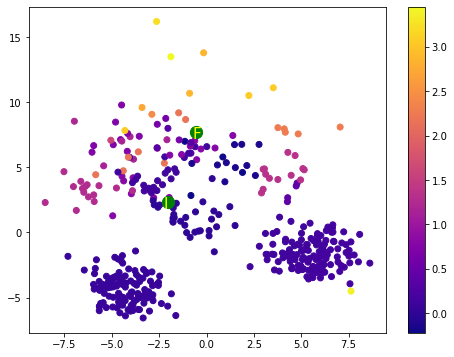

In [90]:
# PCA: 2 components
fig,ax = plt.subplots(figsize=(8,6))
im = ax.scatter(npyfile["pca1"],
          npyfile["pca2"],
          c=npyfile["energy"], 
          cmap='plasma',
        )

plt.colorbar(im)

annotations=["I","F"]
x = [npyfile["pca1"][0],npyfile["pca1"][-1]]
y = [npyfile["pca2"][0],npyfile["pca2"][-1]]
plt.scatter(x,y,s=150, c="green", alpha=1)
for i, label in enumerate(annotations):
    plt.annotate(label, (x[i]-0.2,y[i]-0.5),fontsize=15,c="yellow")

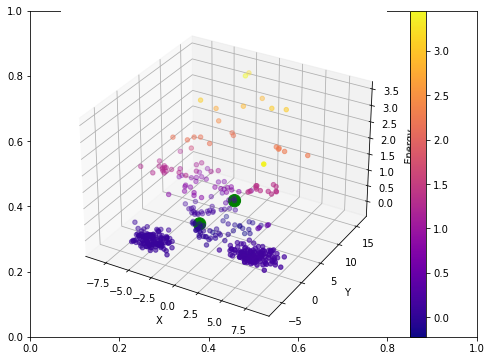

In [91]:
# PCA: 2 components

fig,ax = plt.subplots(figsize=(8,6))
ax = plt.axes(projection ="3d")

im = ax.scatter3D(npyfile["pca1"],
          npyfile["pca2"],
          npyfile["energy"],
          c=npyfile["energy"], 
          cmap='plasma')
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Energy")
plt.colorbar(im)

annotations=["I","F"]
x = [npyfile["pca1"][0],npyfile["pca1"][-1]]
y = [npyfile["pca2"][0],npyfile["pca2"][-1]]
z = [npyfile["energy"][0], npyfile["energy"][-1]]
ax.scatter(x,y,z,s=150,c="green",alpha=1)


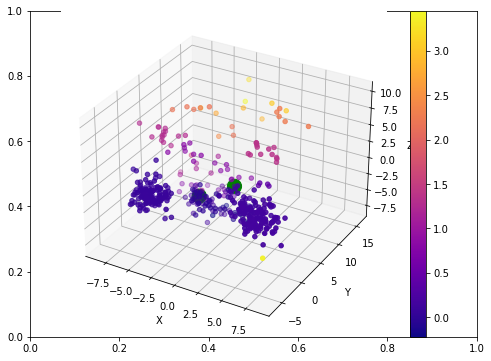

In [92]:
# PCA: 3 components

fig,ax = plt.subplots(figsize=(8,6))
ax = plt.axes(projection ="3d")

im = ax.scatter3D(npyfile["pca1"],
          npyfile["pca2"],
          npyfile["pca3"],
          c=npyfile["energy"],
          cmap='plasma')
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.colorbar(im)

annotations=["I","F"]
x = [npyfile["pca1"][0],npyfile["pca1"][-1]]
y = [npyfile["pca2"][0],npyfile["pca2"][-1]]
z = [npyfile["pca3"][0], npyfile["pca3"][-1]]
ax.scatter(x,y,z,s=200,c="green",alpha=1)

### 2. PHATE Vis

In [141]:
npyfile0 = np.load("data/I1_0_embed.npy")
data_gsae = npyfile0["data_embed"]
data_gsae.shape

(431, 25)

In [151]:
phate_operator = phate.PHATE(n_jobs=-2)
Y_phate = phate_operator.fit_transform(data_gsae)
Y_phate.shape

Calculating PHATE...
  Running PHATE on 431 observations and 25 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculating affinities...
  Calculated graph and diffusion operator in 0.01 seconds.
  Calculating optimal t...
    Automatically selected t = 10
  Calculated optimal t in 0.18 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.03 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 0.12 seconds.
Calculated PHATE in 0.35 seconds.


(431, 2)

In [166]:
""" Save plot data to npy file
"""  
# # save pca coordinates, energy, time data to npy file for Julia plot
# with open('data/I1_0_phateplot.npy', 'wb') as f:
#     np.savez(f,phate=Y_phate,energy=SIM_G,time=SIM_T)

npyphate = np.load("data/I1_0_phateplot.npy")
npyphate.files
Y_phate = npyphate["phate"]

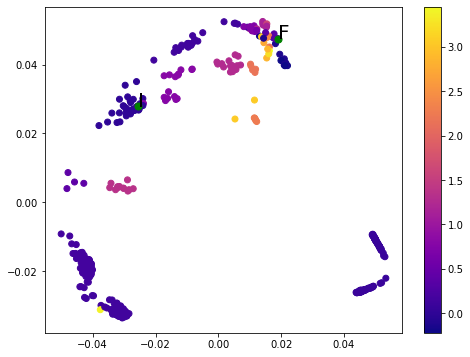

In [174]:
fig,ax = plt.subplots(figsize=(8,6))
im = ax.scatter(Y_phate[:,0],
          Y_phate[:,1],
          c=npyphate["energy"], 
          cmap='plasma',
        )

plt.colorbar(im)

annotations=["I","F"]
x = [Y_phate[:,0][0],Y_phate[:,0][-1]]
y = [Y_phate[:,1][0],Y_phate[:,1][-1]]
plt.scatter(x,y,s=50, c="green", alpha=1)
for i, label in enumerate(annotations):
    plt.annotate(label, (x[i],y[i]),fontsize=20,c="black")